# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
import numpy as np

from keijzer import *

mpl.style.use('default')
%matplotlib inline
sns.set()

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load the data

Get the current system path using some IPython wizardry.  
Note that Jupyter Lab has to be started from within the `Multivariate-time-series-models-in-Keras` folder.  
`pwd` will get the current system path.  
`_` gets the previous cell output and this is assigned to the Python variable `path`.

In [3]:
%pwd

'F:\\Jupyterlab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [4]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string
path

'F:\\Jupyterlab\\Multivariate-time-series-models-in-Keras'

In [5]:
df = pd.read_csv(path+"\\data\\house_data.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])

# Having a quick look at the data

In [6]:
# Just checking how many dwellings there is data from
len(df.dwelling.unique())

52

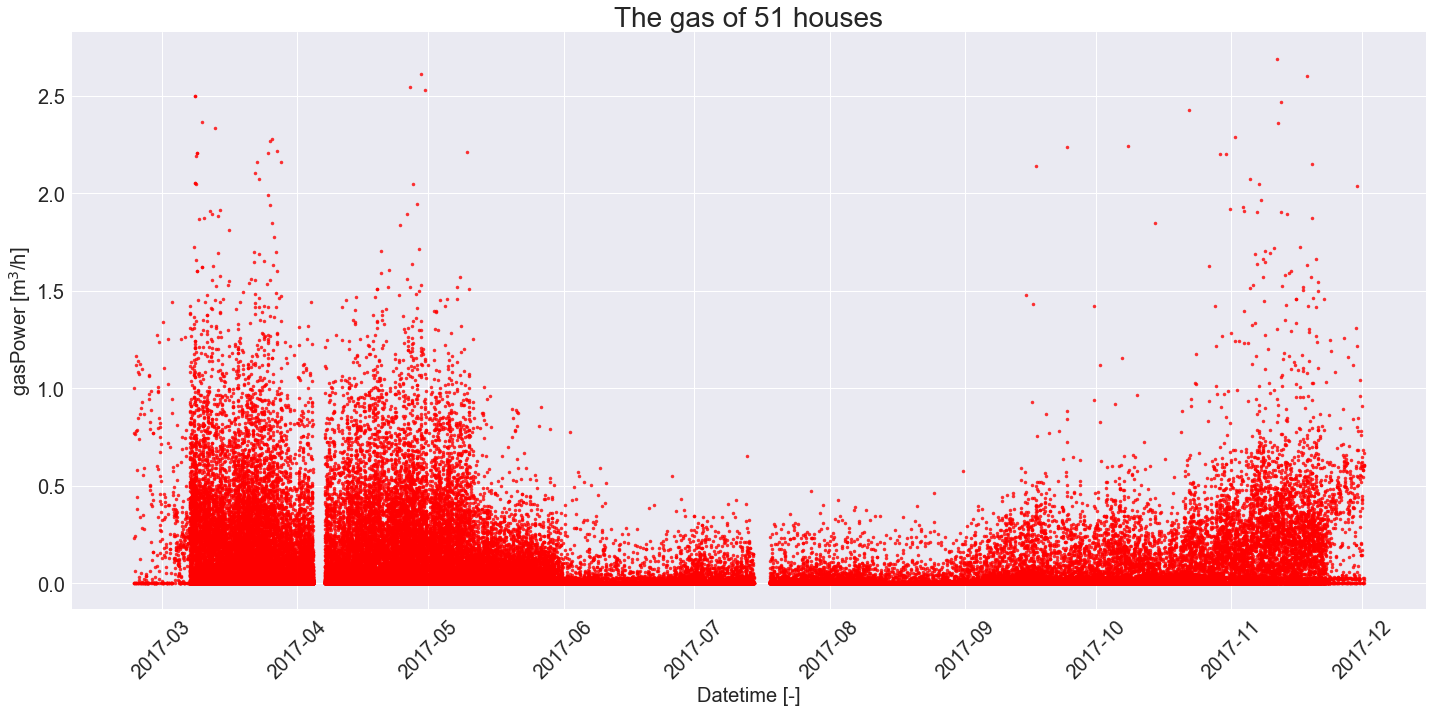

In [7]:
# Plotting the target, gasPower
plt.figure(figsize=(20,10))

plt.plot(df.index, df['gasPower'], '.', color='red', label='Original data', alpha=0.8)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower [m$^3$/h]', fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('The gas of 51 houses', fontsize=28)

plt.tight_layout()

From this plot it is clear that standard deviation (STD) per datetime index is relatively high.  
There also are periods of missing data visible.

# Dealing with missing data

Check the DataFrame for NaNs.

In [8]:
df.isnull().sum()

eMeter              9166
eMeterReturn        9166
eMeterLow           9166
eMeterLowReturn     9166
ePower              9166
ePowerReturn        9166
gasMeter            9246
DD                    88
DR                    55
FF                    88
FX                    88
N                    264
P                     86
Q                     55
RG                    55
SQ                    55
T                     55
T10                   55
TD                    55
U                     55
VV                    55
WW                    55
dwelling               0
gasPower           10156
dtype: int64

There are lots of different ways to deal with the NaNs, we will choose the easy way out and drop them all.  
The main reason for this is that there is no scientific reason to e.g. interpolate the missing data.  
Note that dropping the NaNs makes it so there are gaps in the periodicity of the timestamp.  
For example when there are hours missing, they don't appear as NaN but they simply are not in the DataFrame at all.

In [9]:
df = df.dropna()

# Making sure the missing data appears as NaNs
Resample the DataFrame to an hourly resolution by mean, this will make unsampled periods appear as NaN.  
The `resample_df()` function resamples a DataFrame to the given periodicity and has the ability to combine dwellings.  
Combining dwellings will combine the multiple samples from the same datetime stamp (all the data per house), into one sample for that datetime stamp.  
Simply said, the mean of the weather data and the sum of the `ePower, ePoweReturn, gasPower` data is used.  
This function also drops columns where combining certain feautures of different dwellings would have no scientific meaning.  
There also is a new column added to this DataFrame, `gasPower_std`, this is the standard deviation of the gasPower from all the dwelling at that timestamp.  

<b>This is an important condition to. </b>   
The new DataFrame is on the 'aggregated' level, meaning that it could represent the total power consumption from a block of 51 houses. 

In [10]:
# See keijzer.py for the function definition
df = resample_df(df, 'H', combine_all_dwellings=True)

In [11]:
df.isnull().sum()

ePower          182
ePowerReturn    182
DD              182
DR              182
FF              182
FX              182
N               182
P               182
Q               182
RG              182
SQ              182
T               182
T10             182
TD              182
U               182
VV              182
WW              182
gasPower        182
dwelling          0
gasPower_std    414
dtype: int64

`TODO: Replace these NaNs with 0's? That way the NN might learn what to do with missing data.`  
Dropping the NaNs for now.

In [12]:
df = df.dropna()

# Creating categorical data for the datetime information
In this particular case only `hour`, `dayofweek` and `season` is being used.  
By experimenting these dummy variables helped give the best result.  

In [13]:
# Get all the data out of datetime
# Could also get holiday data: https://stackoverflow.com/questions/29688899/pandas-checking-if-a-date-is-a-holiday-and-assigning-boolean-value

df['hour'] = df.index.hour #create column containing the hour
df['dayofweek'] = df.index.dayofweek
df['season'] = (df.index.month%12 + 3)//3 # Calculates the season (categorical)

#df['month'] = df.index.month
#df['week'] = df.index.week
#df['day'] = df.index.day
#df['year'] = df.index.year

#df['month_end'] = df.index.is_month_end
#df['month_start'] = df.index.is_month_start
#df['quarter_end'] = df.index.is_quarter_end
#df['quarter_start'] = df.index.is_quarter_start

In [14]:
df.head()

,ePower,ePowerReturn,DD,DR,FF,FX,N,P,Q,RG,...,TD,U,VV,WW,gasPower,dwelling,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,0.0,213.524994,0.0,9.067500,13.305000,8.000000,988.431641,112.500000,0.0,...,2.533333,82.666664,45983.332031,2.166667,0.611572,All dwellings,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,0.0,212.316666,0.0,8.684999,12.800000,8.000000,988.431641,144.399994,0.0,...,2.540000,82.000000,42540.000000,2.000000,0.523865,All dwellings,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,0.0,224.399994,0.0,8.296667,11.615000,7.000000,988.398315,151.666672,0.0,...,2.166667,79.666664,41350.000000,1.166667,0.245117,All dwellings,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,0.0,226.983337,0.0,6.918334,9.258333,6.833333,988.248352,246.666672,0.0,...,2.500000,80.833336,45683.332031,1.666667,0.306519,All dwellings,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,0.0,239.449997,0.0,6.583333,9.346666,6.833333,988.598328,212.166672,0.0,...,2.216667,79.166664,44733.332031,2.000000,0.812012,All dwellings,0.014156,16,1,1


# Selecting data to use with the models

At first, lets delete the weather columns which contain correlated information with each other and the feautures we certainly do not need.  
For example, T, T10 and TD are temperature measurements but with just slightly different conditions.  
Only one of those three columns would be of use for us.  
`TODO: Add information about all the feautures`

In [15]:
"""
data = df.copy() usually is handy when the df takes a while to load from disk. 
This way when you mess up, you can just simply run this to 'reset' the data DataFrame.
"""
data = df.copy()

data = data.drop(['dwelling'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated/double information. e.g. T, T10, TD are all three temperature columns.

data = data.drop(['ePowerReturn'], axis=1)

## Data selection based on the Pearson correlation coefficient matrix

As a baseline we will pick the feautures $X$ that have a Pearson correlation coefficient $P$ which suffixes $|P|$ > 0.1 with the target $y$.  
Where the target $y$ is the `gasPower`.  
This is just so we have a baseline of feautures to work with where there is 'some' correlation with the target.  

c:\program files\python36\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Saving heatmap


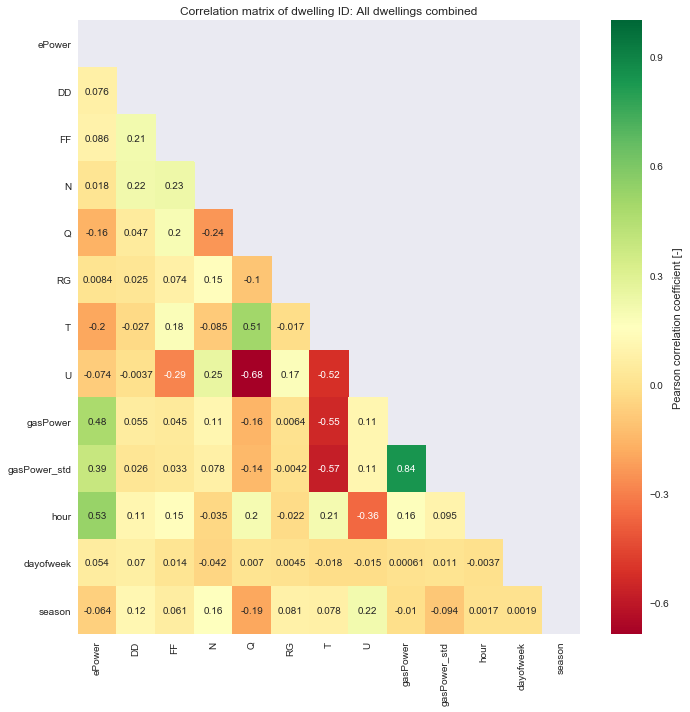

In [16]:
fig = create_corr_matrix(data, 'All dwellings combined', True, size=(10,10))

# Feature engineering 1
Let's look at the scale of our target.

In [17]:
data.describe()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,hour,dayofweek,season
count,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000,6352.000000
mean,288.838632,204.576571,4.041855,4.411799,153.202131,0.117360,13.630328,78.640402,0.073924,0.102031,11.507557,2.991499,3.006770
std,141.040672,79.527240,2.312589,3.174773,217.173316,0.601068,5.293475,14.135467,0.098820,0.107996,6.913092,1.996909,0.820988
min,48.455125,1.850000,0.026667,0.000000,0.000000,0.000000,-1.700000,30.333334,0.000000,0.000000,0.000000,0.000000,1.000000
25%,189.126066,161.687504,2.256250,0.500000,0.166667,0.000000,9.931250,69.000000,0.010219,0.019271,6.000000,1.000000,2.000000
50%,254.492218,221.666664,3.748333,5.333333,25.916667,0.000000,13.783333,80.666664,0.035728,0.070098,12.000000,3.000000,3.000000
75%,356.376946,259.170830,5.456667,7.500000,262.541664,0.000000,17.350000,90.166664,0.098896,0.148916,17.000000,5.000000,4.000000
max,1442.113907,356.816650,13.920000,9.000000,926.500000,18.166666,30.683332,100.000000,1.229492,1.146286,23.000000,6.000000,4.000000


Why look at the scale of the target?  
Later on we will use the Mean Squared Error (MSE) in our models.  

$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i - \hat{Y_i})^2$

We can see that gasPower goes from 0.0 to 1.7, this will result in small MSE values by default (in general).  
To make the MSE more interpretable, we will scale the gasPower by a factor of 10.

In [18]:
magnitude = 1 # specify the power used
data['gasPower'] = data['gasPower']*10**magnitude

# Looking at the selected data

c:\program files\python36\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Saving heatmap


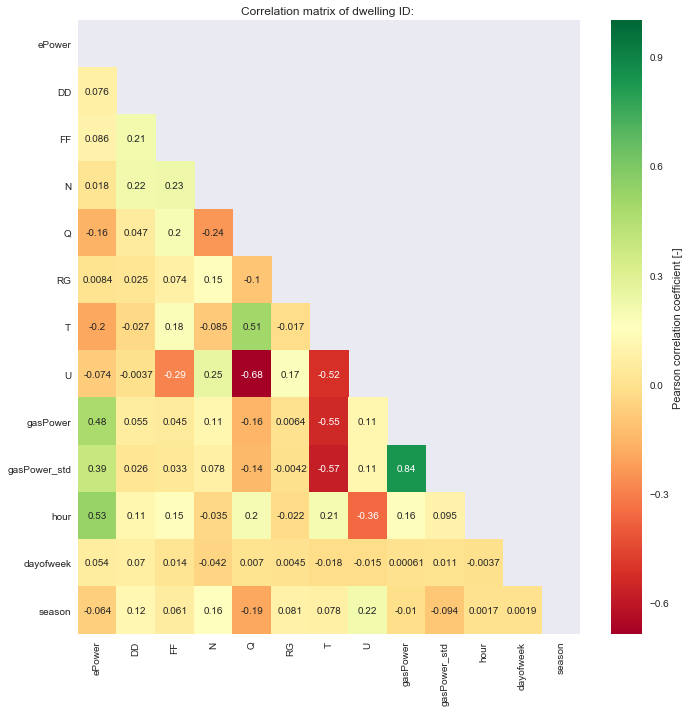

In [18]:
fig = create_corr_matrix(data, '', True, size=(10,10))

In [19]:
# This takes a minute.
#sns.pairplot(data)

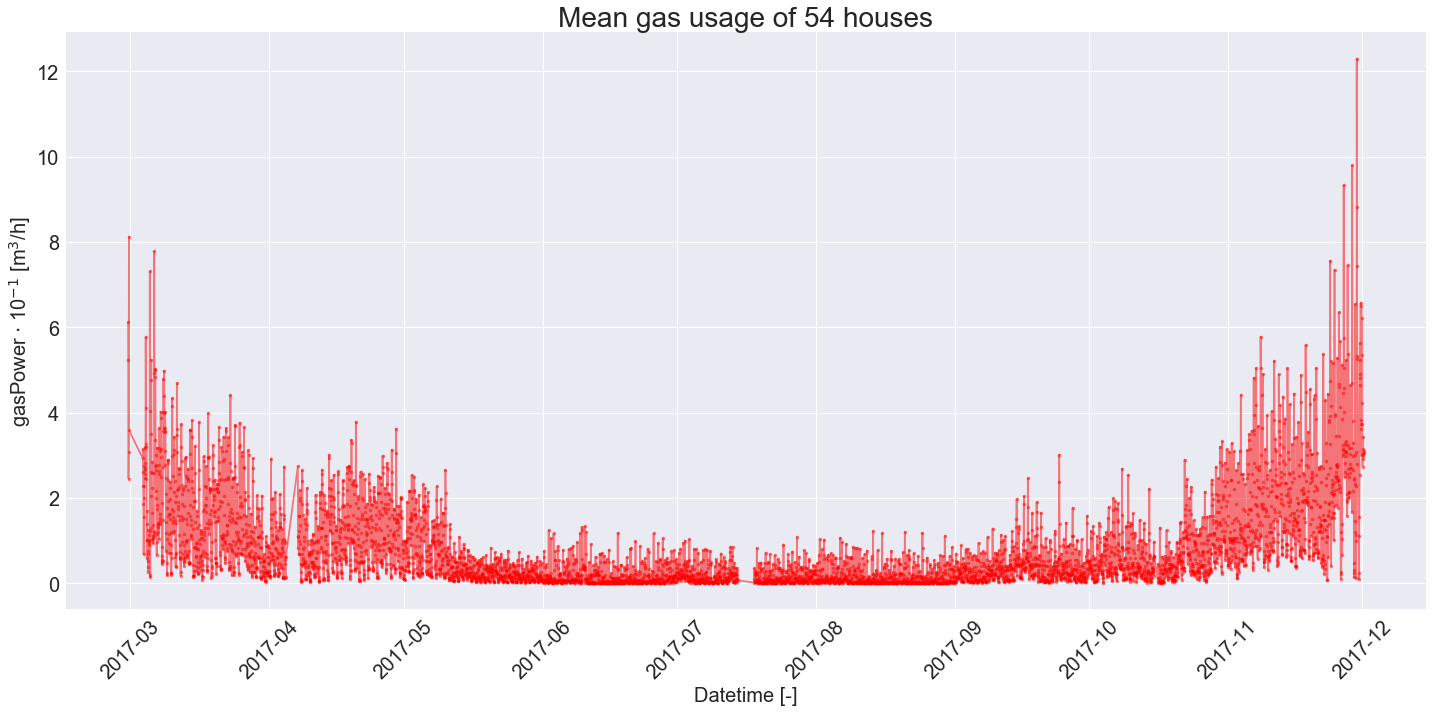

In [25]:
plt.figure(figsize=(20,10))

plt.plot(data.index, data['gasPower'], '.-', color='red', label='Original data', alpha=0.5)
plt.xlabel('Datetime [-]', fontsize=20)
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % (magnitude), fontsize=20)

plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)

plt.title('Mean gas usage of 54 houses', fontsize=28)

plt.tight_layout()

#plt.savefig('figures/available data.png', dpi=1200)

# Save the processed dataframe

In [21]:
data.to_csv(path+"\\data\\house_data_processed.csv", sep='\t')

# Loading the processed data
An example on how to load the processed data.

In [22]:
%pwd

'F:\\Jupyterlab\\Multivariate-time-series-models-in-Keras\\notebooks'

In [23]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

In [24]:
df.head()

,ePower,DD,FF,N,Q,RG,T,U,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,,,,,
2017-02-28 12:00:00,308.321701,213.524994,9.067500,8.000000,112.500000,0.0,5.183333,82.666664,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,212.316666,8.684999,8.000000,144.399994,0.0,5.300000,82.000000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,224.399994,8.296667,7.000000,151.666672,0.0,5.283333,79.666664,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,226.983337,6.918334,6.833333,246.666672,0.0,5.516667,80.833336,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,239.449997,6.583333,6.833333,212.166672,0.0,5.433333,79.166664,8.120117,0.014156,16,1,1
